##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])


########## CREATE INTEGER SEQUENCES AND SPLIT INTO TRAIN, TEST SET ##################
####################################################################################
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

# Try experimenting with the size of that dataset (limiting it to 30000 for faster training)
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
print(max_length_targ, max_length_inp)

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

2646016/2638744 [==============================] - 0s 0us/step
<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>
11 16
24000 24000 6000 6000


### Create a tf.data dataset

In [3]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

# Check one sample batch
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [27]:
##### Bidirectional RNN with 2 layers in Encoder and Unidirectional RNN with 2 layers in Decoder

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    self.layer1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform'))
    self.layer2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform'))
    self.final_h = tf.keras.layers.Dense(self.enc_units)
    self.final_c = tf.keras.layers.Dense(self.enc_units)
    


  def call(self, x, hidden):
    x = self.embedding(x)
    x, h_fw, c_fw, h_bw, c_bw = self.layer1(x, initial_state = hidden)
    output, h_fw, c_fw, h_bw, c_bw = self.layer2(x, initial_state=[h_fw, c_fw, h_bw, c_bw])
    # output = self.bottleneck(x)
    h = self.final_h(tf.concat([h_fw, h_bw], axis=1))
    c = self.final_c(tf.concat([c_fw, c_bw], axis=1))
    return output, h, c

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units)), 
            tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))] 

In [28]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)


# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_h, sample_c = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder h vecotr shape: (batch size, units) {}'.format(sample_h.shape))
print ('Encoder c vector shape: (batch size, units) {}'.format(sample_c.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 2048)
Encoder h vecotr shape: (batch size, units) (64, 1024)
Encoder c vector shape: (batch size, units) (64, 1024)


In [21]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    ######## query : Decoder's Last Hidden State  #####
    ######## values : Encoder Outputs             #####

    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [22]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 2048)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [38]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.layer1 = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.layer2 = tf.keras.layers.LSTM(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, enc_h, enc_c, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(enc_h, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    x, h, c = self.layer1(x, [enc_h, enc_c])
    output, state_h, state_c = self.layer2(x, [h, c])


    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state_h, state_c, attention_weights

In [39]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, dec_h, dec_c, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_h, sample_c, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))
print('Decoder_h shape: ', dec_h.shape)
print('Decoder_c shape: ', dec_c.shape)

Decoder output shape: (batch_size, vocab size) (64, 4935)
Decoder_h shape:  (64, 1024)
Decoder_c shape:  (64, 1024)


## Define the optimizer and the loss function

In [33]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [35]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [43]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_h, enc_c = encoder(inp, enc_hidden)
    print("here")

    dec_h = enc_h
    dec_c = enc_c

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_h, dec_c, _ = decoder(dec_input, dec_h, dec_c, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [45]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  # print(enc_hidden[0].shape, enc_hidden[1].shape)

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.3675
Epoch 1 Batch 100 Loss 0.3877
Epoch 1 Batch 200 Loss 0.3778
Epoch 1 Batch 300 Loss 0.4000
Epoch 1 Loss 0.3876
Time taken for 1 epoch 89.21344470977783 sec

Epoch 2 Batch 0 Loss 0.3085
Epoch 2 Batch 100 Loss 0.3618
Epoch 2 Batch 200 Loss 0.2794
Epoch 2 Batch 300 Loss 0.3326
Epoch 2 Loss 0.3274
Time taken for 1 epoch 90.82079267501831 sec

Epoch 3 Batch 0 Loss 0.2436
Epoch 3 Batch 100 Loss 0.2590
Epoch 3 Batch 200 Loss 0.3140
Epoch 3 Batch 300 Loss 0.2763
Epoch 3 Loss 0.2806
Time taken for 1 epoch 88.6703131198883 sec

Epoch 4 Batch 0 Loss 0.2025
Epoch 4 Batch 100 Loss 0.2606
Epoch 4 Batch 200 Loss 0.2399
Epoch 4 Batch 300 Loss 0.2496
Epoch 4 Loss 0.2420
Time taken for 1 epoch 90.71837019920349 sec

Epoch 5 Batch 0 Loss 0.1925
Epoch 5 Batch 100 Loss 0.1952
Epoch 5 Batch 200 Loss 0.2055
Epoch 5 Batch 300 Loss 0.2567
Epoch 5 Loss 0.2129
Time taken for 1 epoch 88.64816975593567 sec

Epoch 6 Batch 0 Loss 0.1826
Epoch 6 Batch 100 Loss 0.1751
Epoch 6 Batch 200 Loss 

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [51]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units)), tf.zeros((1,units)), tf.zeros((1, units)), tf.zeros((1,units))]
  enc_out, enc_h, enc_c = encoder(inputs, hidden)

  dec_h = enc_h
  dec_c = enc_c

  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_h, dec_c, attention_weights = decoder(dec_input,
                                                         dec_h, dec_c,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [49]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


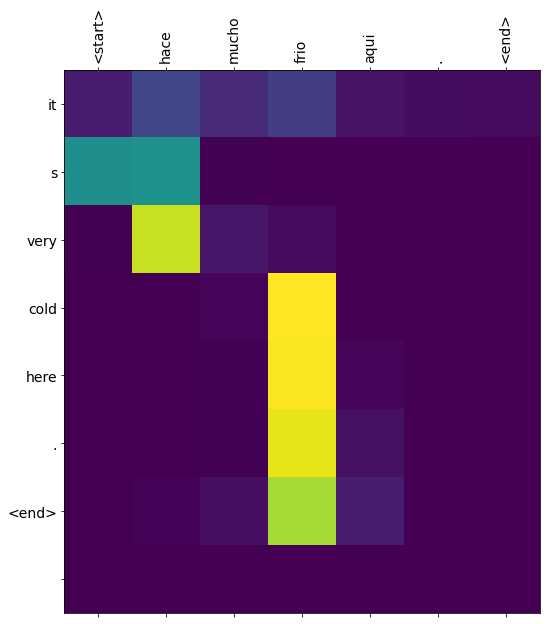

In [53]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


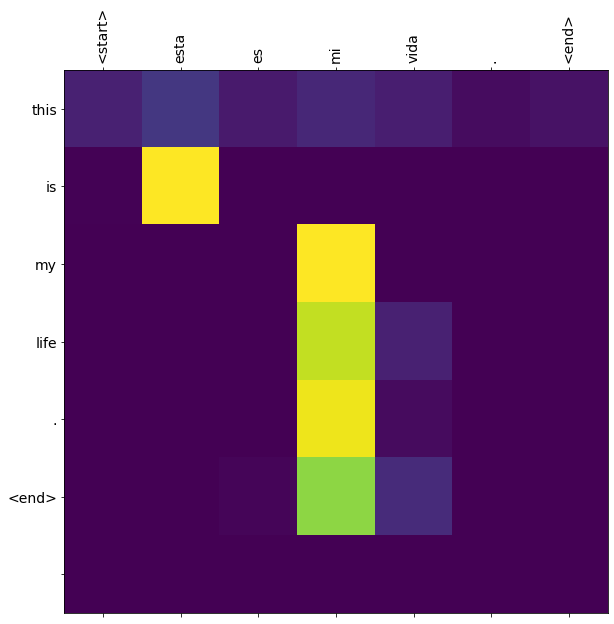

In [54]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still at home ? <end> 


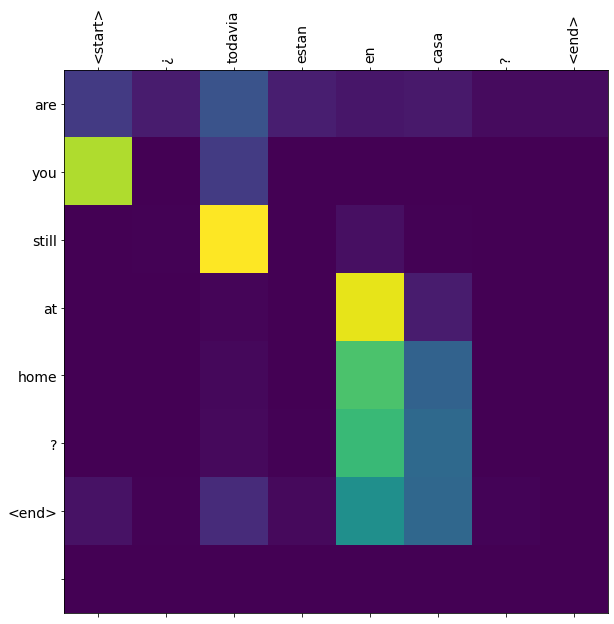

In [55]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to find it . <end> 


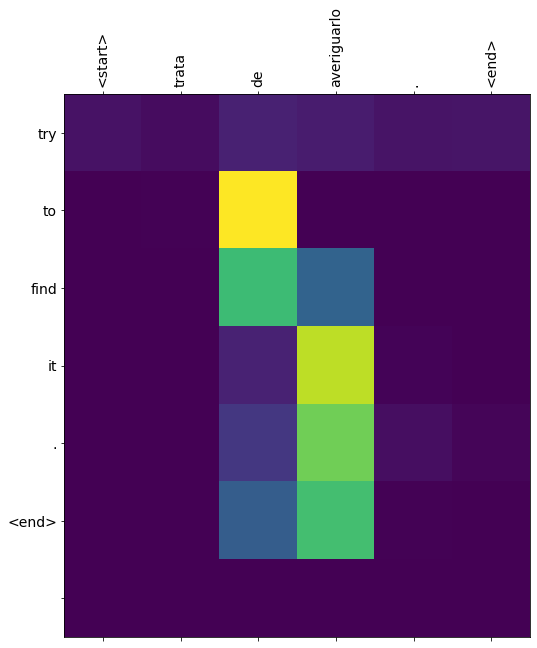

In [56]:
# wrong translation
translate(u'trata de averiguarlo.')

In [57]:
test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

print(test_dataset.element_spec)
print(input_tensor_val.shape)

def translate_batch(test_dataset):
  with open('output_text.txt', 'w') as f:
    for (inputs, targets) in test_dataset:
      outputs = np.zeros((BATCH_SIZE, max_length_targ),dtype=np.int16)
      hidden_state = [tf.zeros((BATCH_SIZE, units)), tf.zeros((BATCH_SIZE, units)), tf.zeros((BATCH_SIZE, units)), tf.zeros((BATCH_SIZE, units))] 
      enc_output, dec_h, dec_c = encoder(inputs, hidden_state)
      dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
      for t in range(max_length_targ):
        preds, dec_h, dec_c,  _ = decoder(dec_input, dec_h, dec_c, enc_output)
        predicted_id = tf.argmax(preds, axis=1).numpy()
        outputs[:, t] = predicted_id
        dec_input = tf.expand_dims(predicted_id, 1)
      outputs = targ_lang.sequences_to_texts(outputs)
      for t, item in enumerate(outputs):
        try:
          i = item.index('<end>')
          f.write("%s\n" %item[:i])
        except: 
          f.write("%s \n" % item)

outputs = translate_batch(test_dataset)

(TensorSpec(shape=(64, 16), dtype=tf.int32, name=None), TensorSpec(shape=(64, 11), dtype=tf.int32, name=None))
(6000, 16)


In [58]:
!head output_text.txt
! wc -l output_text.txt

where do you mean ? 
you re very pretty . 
this was good advice . 
what s in the box ? 
tom is in boston . 
tom was really drunk . 
try it on . 
i can confirm this . 
i missed you . 
he s her friend . 
5952 output_text.txt


## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs


In [59]:
targ_lang.sequences_to_texts(target_tensor_val)[:5]

['<start> where do you want it ? <end>',
 '<start> you re very pretty . <end>',
 '<start> this must be yours . <end>',
 '<start> what s in the bottle ? <end>',
 '<start> tom is in bed . <end>']